# 1. Overview

# 2. Future Predictions

## 2.1 Import Libraries

In [1]:
import pandas as pd
import joblib
from sktime.utils.plotting import plot_series
from prophet import Prophet


C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.2 Define Global Variables

In [2]:
# Define the dictionary with file names and suppliers
company_tickers = {
    'CZMWY': 'Carl Zeiss Meditec',
    'LRCX': 'Lam Research Corporation',
    'TOELY': 'Tokyo Electron Limited'
}

regressors = ['Close_Carl_Zeiss_Meditec', 'Close_Lam_Research_Corporation', 
              'Close_Tokyo_Electron_Limited', 'COVID_Period', 
              'Geopolitical_Tension', 'Trade_Sanctions', 
              'Tech_Regulation', 'New_Product_Launch']

output_model_path_asml_suppliers = 'models/prophet_asml_combination_with_suppliers.pkl'
input_data = 'data/weekly_data_combination.csv'
future_weeks = 2


## 2.3 Functions

In [3]:
# Function to add exogenous variables to the future_dataframe
def add_exogenous_variables(future_df):
    """
    Input: future_df (DataFrame) - A DataFrame containing future dates in the 'ds' column.
    Output: future_df (DataFrame) - The same DataFrame with added binary columns for each exogenous event.
    Logic: Adds binary indicators for each specified geopolitical and economic event based on predefined date ranges.
    """
    
    # Define the date ranges for each exogenous event
    covid_start = '2020-01-01'
    covid_end = '2022-12-31'

    geopolitical_tension_start = '2022-02-01'
    geopolitical_tension_end = '2025-12-31'

    trade_sanctions_start = '2018-07-01'
    trade_sanctions_end = '2029-12-31'

    tech_regulation_start = '2020-06-01'
    tech_regulation_end = '2029-12-31'

    new_product_launch_start = '2023-12-01'
    new_product_launch_end = '2025-12-31'

    israel_gaza_conflict_start = '2023-10-07'
    israel_gaza_conflict_end = '2025-12-31'

    # COVID Period
    future_df['COVID_Period'] = ((future_df['ds'] >= covid_start) & 
                                 (future_df['ds'] <= covid_end)).astype(int)
    
    # Geopolitical Tensions (Ukraine Conflict)
    future_df['Geopolitical_Tension'] = ((future_df['ds'] >= geopolitical_tension_start) & 
                                         (future_df['ds'] <= geopolitical_tension_end)).astype(int)
    
    # US-China Trade War
    future_df['Trade_Sanctions'] = ((future_df['ds'] >= trade_sanctions_start) & 
                                    (future_df['ds'] <= trade_sanctions_end)).astype(int)
    
    # Tech Regulation (Export Restrictions)
    future_df['Tech_Regulation'] = ((future_df['ds'] >= tech_regulation_start) & 
                                    (future_df['ds'] <= tech_regulation_end)).astype(int)
    
    # New EUV Machine Launch (TWINSCAN EXE:5000)
    future_df['New_Product_Launch'] = ((future_df['ds'] >= new_product_launch_start) & 
                                       (future_df['ds'] <= new_product_launch_end)).astype(int)
    
    # Israel-Gaza Conflict
    future_df['Israel_Gaza_Conflict'] = ((future_df['ds'] >= israel_gaza_conflict_start) & 
                                         (future_df['ds'] <= israel_gaza_conflict_end)).astype(int)

## 2.4 Code

### 2.4.1 Loading the data from notebook 04_data_preparation

In [4]:
weekly_data_combination = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data_combination['Date'] = pd.to_datetime(weekly_data_combination['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data_combination.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data_combination = weekly_data_combination.asfreq('W')

# Replace spaces with underscores in column names
weekly_data_combination.columns = [col.replace(" ", "_") for col in weekly_data_combination.columns]

weekly_data_combination

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
Date,,,,,,,,,,,
2013-01-13,56.546021,26.057861,2.061523,7.480000,0,0,0,0,0,0,0
2013-01-20,57.203339,27.226334,2.102677,7.460000,0,0,0,0,0,0,0
2013-01-27,62.106480,27.674397,2.199800,7.406667,0,0,0,0,0,0,0
2013-02-03,66.858604,28.728662,2.289240,7.140000,0,0,0,0,0,0,0
2013-02-10,67.498169,29.343649,2.335880,6.853333,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-13,832.038757,72.779999,82.059998,86.790001,0,1,1,1,1,1,0
2024-10-20,721.585144,67.094002,74.139999,81.540001,0,1,1,1,1,1,0
2024-10-27,710.051941,67.529999,73.000000,76.709999,0,1,1,1,1,1,0


### 2.4.2 Loading Suppliers Pickles

In [5]:
# Create an empty dictionary to store the loaded models
models_suppliers = {}

# Iterate over each supplier in company_tickers to load its model
for ticker, company in company_tickers.items():
    # Define the file path to the model pickle file for the current supplier
    model_path = f'models/prophet_asml_supplier_{company.replace(" ", "_")}.pkl'
    
    # Load the model and store it in the dictionary using the supplier's name
    models_suppliers[company] = joblib.load(model_path)
    print(f'Prophet model for {company} loaded from {model_path}')

Prophet model for Carl Zeiss Meditec loaded from models/prophet_asml_supplier_Carl_Zeiss_Meditec.pkl
Prophet model for Lam Research Corporation loaded from models/prophet_asml_supplier_Lam_Research_Corporation.pkl
Prophet model for Tokyo Electron Limited loaded from models/prophet_asml_supplier_Tokyo_Electron_Limited.pkl


### 2.4.3 Train the model with new data

The prophet model that was trained in notebook 05_modelling, we are going to train it again with all the data without separating between train and test. 

In [6]:
prophet_model = Prophet(
    changepoint_prior_scale= 0.07, 
    daily_seasonality= False, 
    holidays_prior_scale= 0.1, 
    seasonality_mode= 'additive', 
    seasonality_prior_scale= 1.5, 
    weekly_seasonality= True, 
    yearly_seasonality= False
)

Modify the column names as required by prophet

In [7]:
train_data = weekly_data_combination.reset_index(names="ds").rename(columns={'Close_ASML':'y'})

Add regressors

In [8]:
for regressor in regressors:
    prophet_model.add_regressor(regressor)

Fit the model

In [9]:
prophet_model.fit(train_data)

15:56:20 - cmdstanpy - INFO - Chain [1] start processing
15:56:20 - cmdstanpy - INFO - Chain [1] done processing


### 2.4.4 Building the future dataframe

In [10]:
future_dataframe = prophet_model.make_future_dataframe(periods=future_weeks, freq='w')[-future_weeks:]
future_dataframe

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  dates = pd.date_range(


,ds
618,2024-11-17
619,2024-11-24


Predict the stock of ASML's suppliers using the prophet models of the suppliers that were done in notebook 03_selecting_asml_suppliers

In [11]:
# Iterate over each supplier in company_tickers to make predictions
for ticker, company in company_tickers.items():
    # Get the loaded Prophet model for the current supplier from the models_suppliers dictionary
    model = models_suppliers[company]
    
    # Generate predictions on the future_dataframe using the model
    forecast = model.predict(future_dataframe)
    
    # Select only 'ds' and 'yhat' columns, rename 'yhat' to 'Close_{company}'
    forecast = forecast[['ds', 'yhat']].rename(columns={'yhat': f'Close_{company.replace(" ", "_")}'})
    
    # Merge the forecast data with the future_dataframe on the 'ds' column
    future_dataframe = future_dataframe.merge(forecast, on='ds', how='left')

In [12]:
future_dataframe

,ds,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited
0,2024-11-17,69.031557,89.705845,93.968502
1,2024-11-24,68.241050,90.929548,95.377398


Let's predict the exogenous variables into the future and add them to the future_dataframe as well 

In [13]:
# Apply the function to future_dataframe
add_exogenous_variables(future_dataframe)

future_dataframe

,ds,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
0,2024-11-17,69.031557,89.705845,93.968502,0,1,1,1,1,1
1,2024-11-24,68.241050,90.929548,95.377398,0,1,1,1,1,1


### 2.4.5 Predicting the stock values of ASML 

In [14]:
# Generate predictions
future_dataframe_ASML_stock = prophet_model.predict(future_dataframe)

# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
future_dataframe_ASML_stock = future_dataframe_ASML_stock[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})

future_dataframe_ASML_stock

,Close
ds,
2024-11-17,876.439546
2024-11-24,884.638415


Let's do a representation of the results

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Close_ASML'>)

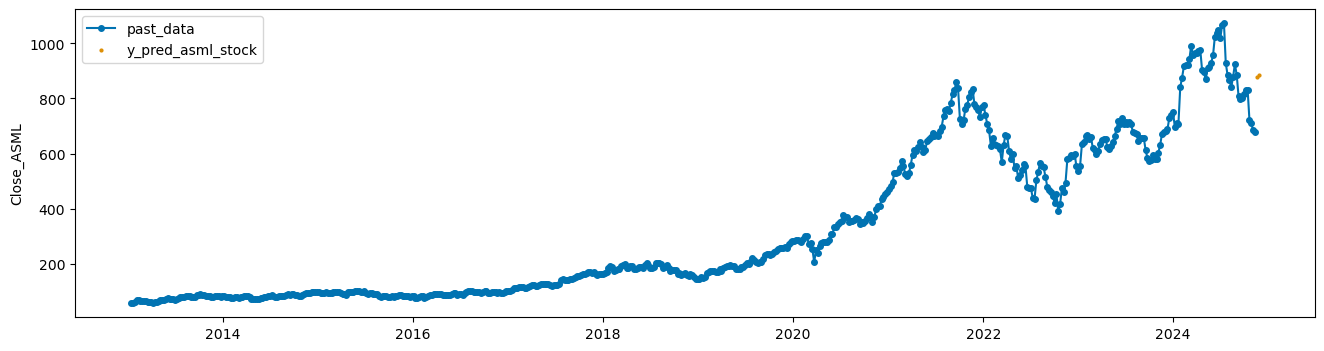

In [15]:
# Plot the series with train, test, and predictions from both models
plot_series(
    weekly_data_combination['Close_ASML'],             # Training data starting from index 500 for better visualization
    future_dataframe_ASML_stock,                       # Predictions from the ASML model
    labels=["past_data", "y_pred_asml_stock"]          # Labels for each line in the plot
)